# ITU YZV302(3)E Deep Learning Course Fall 2024

# HW3

# Q3: Time Series Prediction (40 pts)

In this notebook, you will predict traffic density by using recurrent neural networks on ibb traffic dataset. The IBB traffic dataset can be downloaded from the IBB data lake. 
Here you shall locate a specific traffic sensor with given coordinates. For example, locate the one on one of the bridges. Retrieve its traffic density (number of vehicles). 

* a) First explore the data. Plot it. Analyse its behaviour, periodicity (seasonality), trends etc. Discuss how these might impact your predictions (2.5 pts)  
* b) Prepare the training and test sets by windowing the dataset. Choose a windowing pattern (for example use 1 previous steps to predict the next time step). This is the simplest case. (2.5 pts)
* c) Compare the performance of the following (35 pts)
* 1) baseline predictor (repeat the previous value), (2.5 pts)
  2) linear layer(2.5 pts)
  3) RNN,(9 pts)
  4) CNN (9 pts)
* Advanced Methods: You can try something else (temporal convolution network or you can learn to use a huggingface pre-trained transformer model work) (12pts)

## Load and prepare the data

Start by loading and preparing the data.  This is what I have downloaded. 

https://data.ibb.gov.tr/dataset/hourly-traffic-density-data-set/resource/0c7d60f3-8349-4836-a1c2-56ec93cbbd50


In [1]:
import torch
import numpy as np
import torchvision
import random
import os
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# For standardized outputs

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed = 42
seed_everything(seed)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
import pandas as pd

df = pd.read_csv("./data/traffic_density__202410.csv")

df.head()

,DATE_TIME,LONGITUDE,LATITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2024-10-01 00:00:00,28.800659,41.091614,sxk3z2,29,72,47,9
1,2024-10-01 00:00:00,28.789673,41.097107,sxk3z1,9,95,47,26
2,2024-10-01 00:00:00,28.547974,41.228943,sxk699,86,111,92,2
3,2024-10-01 00:00:00,28.690796,41.047668,sxk3sb,10,120,63,175
4,2024-10-01 00:00:00,28.811646,41.141052,sxk6p9,33,155,86,132


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912237 entries, 0 to 912236
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DATE_TIME           912237 non-null  object 
 1   LONGITUDE           912237 non-null  float64
 2   LATITUDE            912237 non-null  float64
 3   GEOHASH             912237 non-null  object 
 4   MINIMUM_SPEED       912237 non-null  int64  
 5   MAXIMUM_SPEED       912237 non-null  int64  
 6   AVERAGE_SPEED       912237 non-null  int64  
 7   NUMBER_OF_VEHICLES  912237 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.7+ MB


In [6]:
df.describe()

,LONGITUDE,LATITUDE,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
count,912237.000000,912237.000000,912237.000000,912237.000000,912237.000000,912237.000000
mean,28.887013,41.062908,22.684148,102.593290,56.333093,115.186876
std,0.356655,0.100918,24.356747,37.603207,26.290157,145.663175
min,27.965698,40.767517,1.000000,2.000000,2.000000,1.000000
25%,28.690796,40.998230,3.000000,72.000000,32.000000,22.000000
50%,28.932495,41.058655,10.000000,101.000000,54.000000,63.000000
75%,29.152222,41.130066,42.000000,131.000000,80.000000,149.000000
max,29.635620,41.344299,189.000000,250.000000,192.000000,1678.000000


## Selected coordinates

I selected the 3rd bridge.

(41.205707, 29.105579)


In [7]:
df['Distance'] = ((df['LATITUDE'] - 41.205707)**2 + (df['LONGITUDE'] - 29.105579)**2)**0.5

In [8]:
# Select the sensor with the smallest distance
closest_sensor = df.loc[df['Distance'].idxmin()]
df_filtered = df[df["GEOHASH"] == closest_sensor["GEOHASH"]]
df_filtered.head()

,DATE_TIME,LONGITUDE,LATITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES,Distance
2172,2024-10-01 00:00:00,29.108276,41.20697,sxkdqm,63,179,86,140,0.002979
2399,2024-10-01 01:00:00,29.108276,41.20697,sxkdqm,55,133,87,119,0.002979
5753,2024-10-01 02:00:00,29.108276,41.20697,sxkdqm,55,129,85,95,0.002979
9000,2024-10-01 03:00:00,29.108276,41.20697,sxkdqm,66,137,87,66,0.002979
9391,2024-10-01 04:00:00,29.108276,41.20697,sxkdqm,36,153,89,76,0.002979


In [9]:
df_filtered.to_csv("./data/filtered_data.csv", index=False)

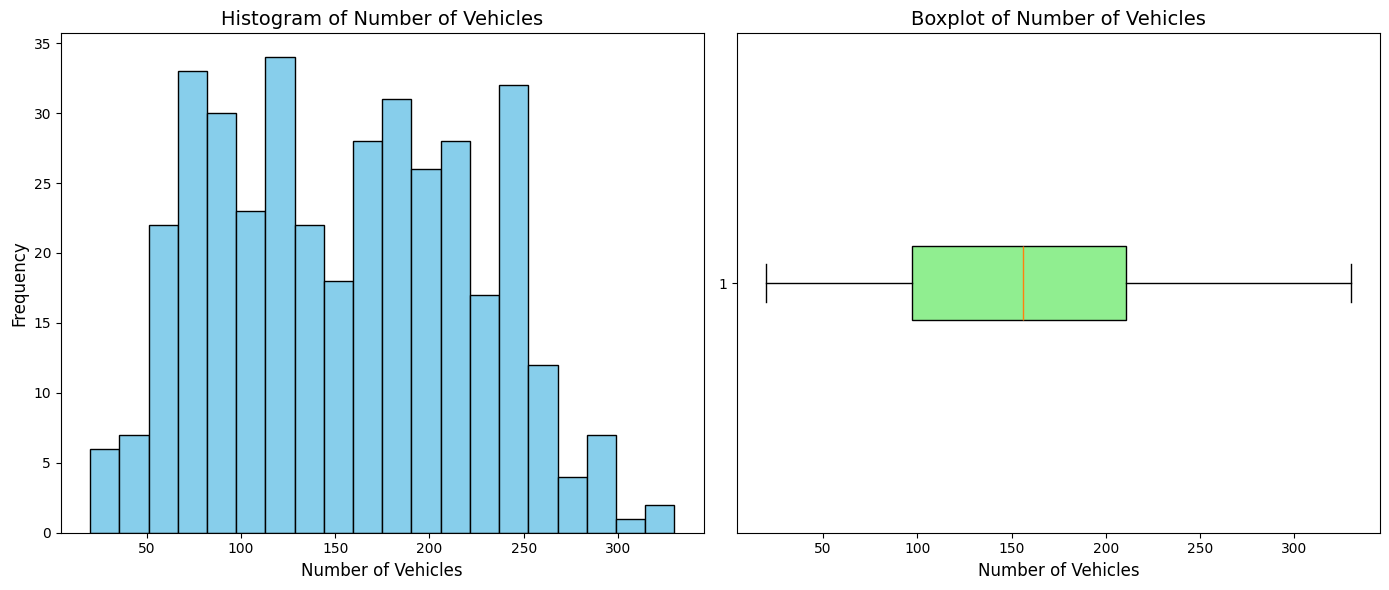

In [10]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(df_filtered['NUMBER_OF_VEHICLES'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Number of Vehicles', fontsize=14)
plt.xlabel('Number of Vehicles', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
plt.boxplot(df_filtered['NUMBER_OF_VEHICLES'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Boxplot of Number of Vehicles', fontsize=14)
plt.xlabel('Number of Vehicles', fontsize=12)
plt.tight_layout()
plt.show()


<Figure size 600x1200 with 0 Axes>

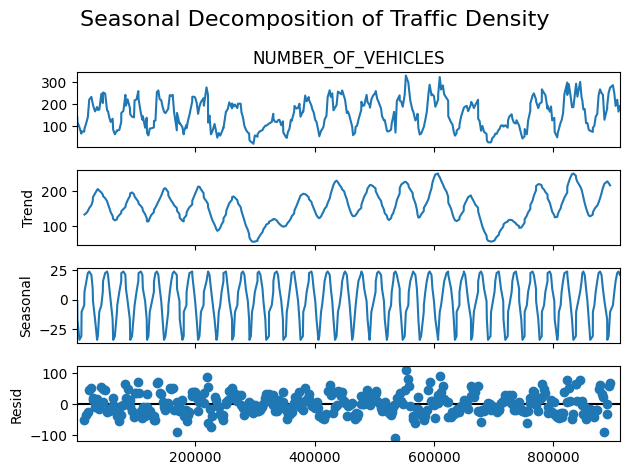

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_filtered['NUMBER_OF_VEHICLES'], model='additive', period=12)  

plt.figure(figsize=(6, 12))
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Traffic Density', fontsize=16)
plt.tight_layout()
plt.show()


<span style="color:red;">Analysis:</span> I inspect that the there is pattern with 8 hour cyycle as morning, noon, evening. It could be useful. Lag features can be useful.

## Divide the data into train and test set parts. 
I used last 110 samples for test and remaining for train. 

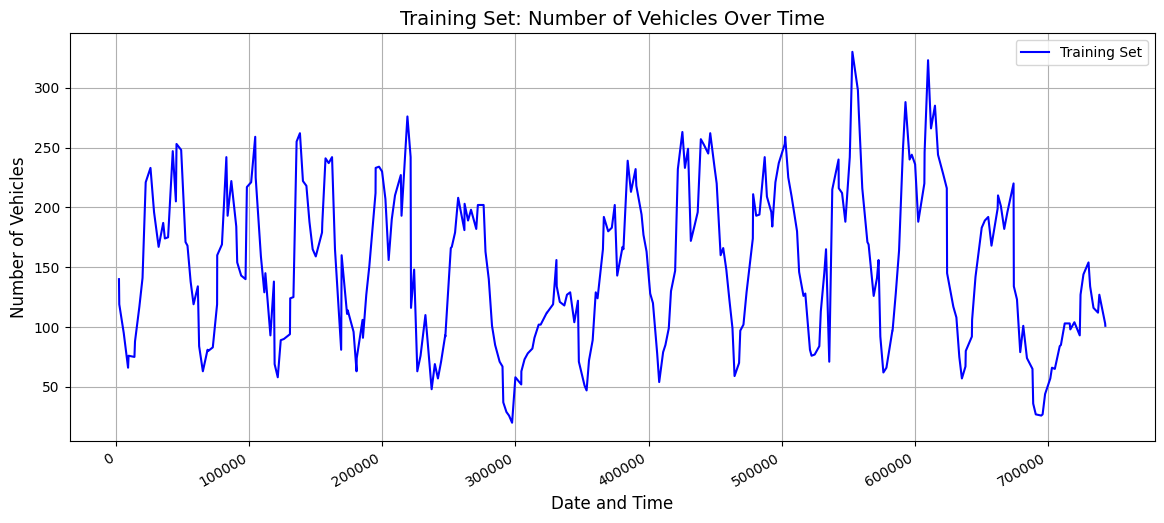

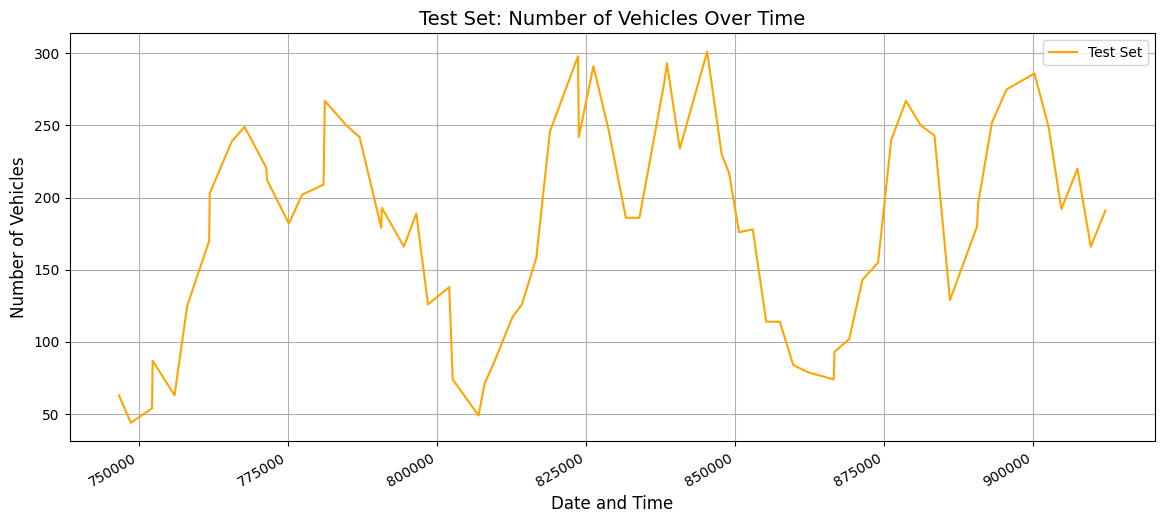

In [12]:
test_set = df_filtered.iloc[-70:]  
training_set = df_filtered.iloc[:-70]  

plt.figure(figsize=(14, 6))
plt.plot(training_set.index, training_set['NUMBER_OF_VEHICLES'], label='Training Set', color='blue')
plt.title('Training Set: Number of Vehicles Over Time', fontsize=14)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Number of Vehicles', fontsize=12)
plt.legend()
plt.grid()
plt.gcf().autofmt_xdate()  
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(test_set.index, test_set['NUMBER_OF_VEHICLES'], label='Test Set', color='orange')
plt.title('Test Set: Number of Vehicles Over Time', fontsize=14)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Number of Vehicles', fontsize=12)
plt.legend()
plt.grid()
plt.gcf().autofmt_xdate()  
plt.show()


## Write a function to prepare the input-target pairs. 
The function basically receives the dataframe and returns X, y numpy arrays with the given prediction window size. 

We can use the actual number of vehicles value, but I scaled it, divided the number of vehicles to 1000 to make the range simple.

In [13]:
import numpy as np

SCALER = 1000.0
def prepare_input_sequences(data, window_size):
    data = data / SCALER

    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size]) 
        y.append(data[i + window_size])  

    X = np.array(X)
    y = np.array(y)

    return X, y

window_size = 8 
data = training_set['NUMBER_OF_VEHICLES'].values

X_train, y_train = prepare_input_sequences(data, window_size)

data_test = test_set['NUMBER_OF_VEHICLES'].values
X_test, y_test = prepare_input_sequences(data_test, window_size)

print("Shape of input sequences (X_train):", X_train.shape)
print("Shape of target values (y_train):", y_train.shape)
print("Shape of input sequences (X_test):", X_test.shape)
print("Shape of target values (y_test):", y_test.shape)


Shape of input sequences (X_train): (305, 8)
Shape of target values (y_train): (305,)
Shape of input sequences (X_test): (62, 8)
Shape of target values (y_test): (62,)


## a) Calculate a baseline Prediction score by repeating the previous value

For example:

y_test
array([0.537, 0.592, 0.538, 0.61 ])

prediction is 

array([0.144, 0.537, 0.592, 0.538])



In [14]:
baseline_predictions = y_test
baseline_predictions = np.roll(baseline_predictions, 1)

baseline_mae = np.mean(np.abs(baseline_predictions[1:] - y_test[1:]))

print("Baseline MAE:", baseline_mae)

Baseline MAE: 0.0342622950819672


## Plot the baseline prediction vs y_test on the same plot

Yes, it looks very similar acceptible but that is a bit illusion. See the error plot. Which shows errors in each time-step

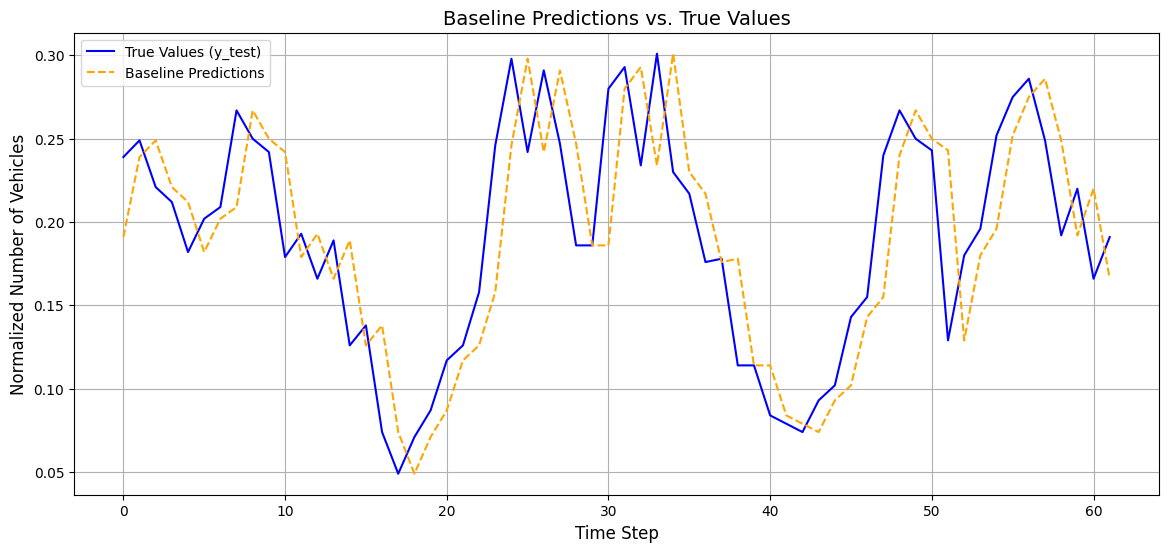

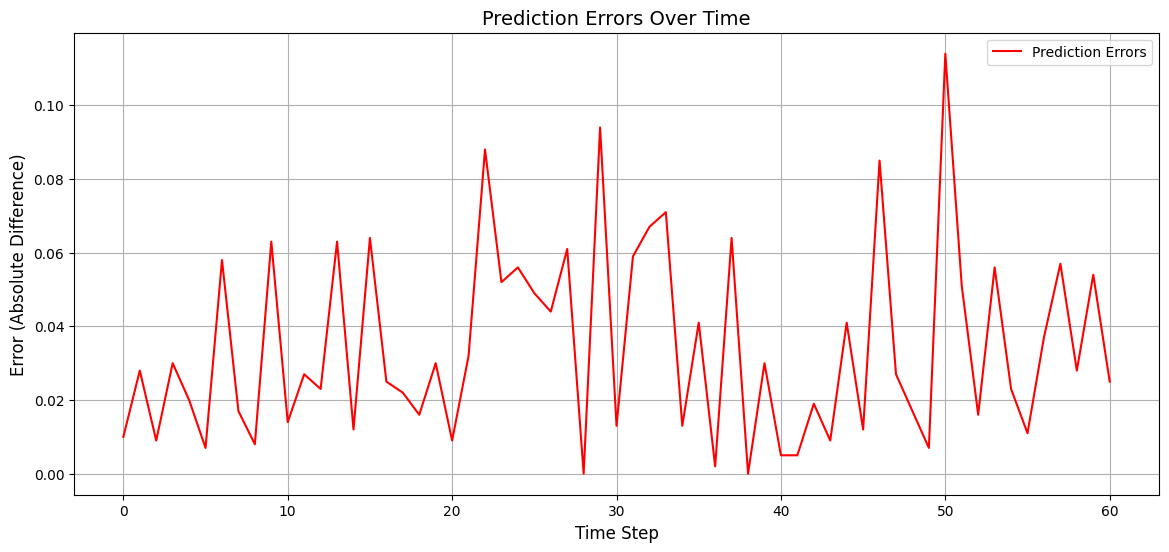

In [15]:
def plot_results(name, predictions, y):
    plt.figure(figsize=(14, 6))
    plt.plot(y, label='True Values (y_test)', color='blue')
    plt.plot(predictions, label=f'{name} Predictions', color='orange', linestyle='--')
    plt.title(f'{name} Predictions vs. True Values', fontsize=14)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Normalized Number of Vehicles', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

    errors = np.abs(predictions[1:] - y[1:])
    plt.figure(figsize=(14, 6))
    plt.plot(errors, label='Prediction Errors', color='red')
    plt.title('Prediction Errors Over Time', fontsize=14)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Error (Absolute Difference)', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

plot_results(name="Baseline", predictions=baseline_predictions, y=y_test)

### Implement a model trainer, given a model, x and y , criterion, optimizer, batch_size and epochs it trains a a model

* I recommend starting with batch_size=1, because data is so small. Also you may need a grad_clip in some cases to control the exploding gradient.


### Implement a linear model.  LinearPredictor 


You can try with different predictor window_sizes my result is just using previous 6 value to predict the next value. Linear(1,1)

In [45]:
import torch.nn as nn
import torch.optim as optim

class LinearPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearPredictor, self).__init__()
        self.linear1 = nn.Linear(input_size, input_size//2)
        self.linear2 = nn.Linear(input_size//2, output_size)

    def forward(self, x):
        return self.linear2(self.linear1(x))


In [33]:
window_size = 8 
data = training_set['NUMBER_OF_VEHICLES'].values

X_train, y_train = prepare_input_sequences(data, window_size)

data_test = test_set['NUMBER_OF_VEHICLES'].values
X_test, y_test = prepare_input_sequences(data_test, window_size)

In [34]:
input_size = window_size
output_size = 1
linear_model = LinearPredictor(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(linear_model.parameters(), lr=0.001820350838028775)

print(linear_model)

LinearPredictor(
  (linear1): Linear(in_features=8, out_features=4, bias=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [17]:
def train_model(model, X, y, criterion, optimizer, batch_size, epochs, grad_clip=None, verbose=False):
    model.to(device)
    model.train()
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.float32).to(device)

    for epoch in range(epochs):
        epoch_loss = 0.0
        for i in range(0, len(X), batch_size):
            batch_X = X[i:i + batch_size]
            batch_y = y[i:i + batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()

            if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            epoch_loss += loss.item()
            
        if verbose:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(X):.6f}")

In [35]:
train_model(linear_model, X_train, y_train, criterion, batch_size=64, optimizer=optimizer, epochs=250, grad_clip=3.0585454600367044, verbose=True)

Epoch 1/250, Loss: 0.000415
Epoch 2/250, Loss: 0.000254
Epoch 3/250, Loss: 0.000151
Epoch 4/250, Loss: 0.000095
Epoch 5/250, Loss: 0.000071
Epoch 6/250, Loss: 0.000066
Epoch 7/250, Loss: 0.000066
Epoch 8/250, Loss: 0.000067
Epoch 9/250, Loss: 0.000066
Epoch 10/250, Loss: 0.000064
Epoch 11/250, Loss: 0.000061
Epoch 12/250, Loss: 0.000060
Epoch 13/250, Loss: 0.000059
Epoch 14/250, Loss: 0.000058
Epoch 15/250, Loss: 0.000057
Epoch 16/250, Loss: 0.000056
Epoch 17/250, Loss: 0.000055
Epoch 18/250, Loss: 0.000054
Epoch 19/250, Loss: 0.000053
Epoch 20/250, Loss: 0.000053
Epoch 21/250, Loss: 0.000052
Epoch 22/250, Loss: 0.000051
Epoch 23/250, Loss: 0.000050
Epoch 24/250, Loss: 0.000049
Epoch 25/250, Loss: 0.000049
Epoch 26/250, Loss: 0.000048
Epoch 27/250, Loss: 0.000047
Epoch 28/250, Loss: 0.000047
Epoch 29/250, Loss: 0.000046
Epoch 30/250, Loss: 0.000045
Epoch 31/250, Loss: 0.000045
Epoch 32/250, Loss: 0.000044
Epoch 33/250, Loss: 0.000043
Epoch 34/250, Loss: 0.000043
Epoch 35/250, Loss: 0.0

In [18]:
def evaluate_model(model, X_test, y_test, model_name="DEMO", verbose=False):
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        predictions = model(X_test_tensor).cpu().squeeze().numpy()
    
    if verbose:
        plot_results(f"{model_name}", predictions, y_test)

    mae = np.mean(np.abs(predictions - y_test))
    return mae
    

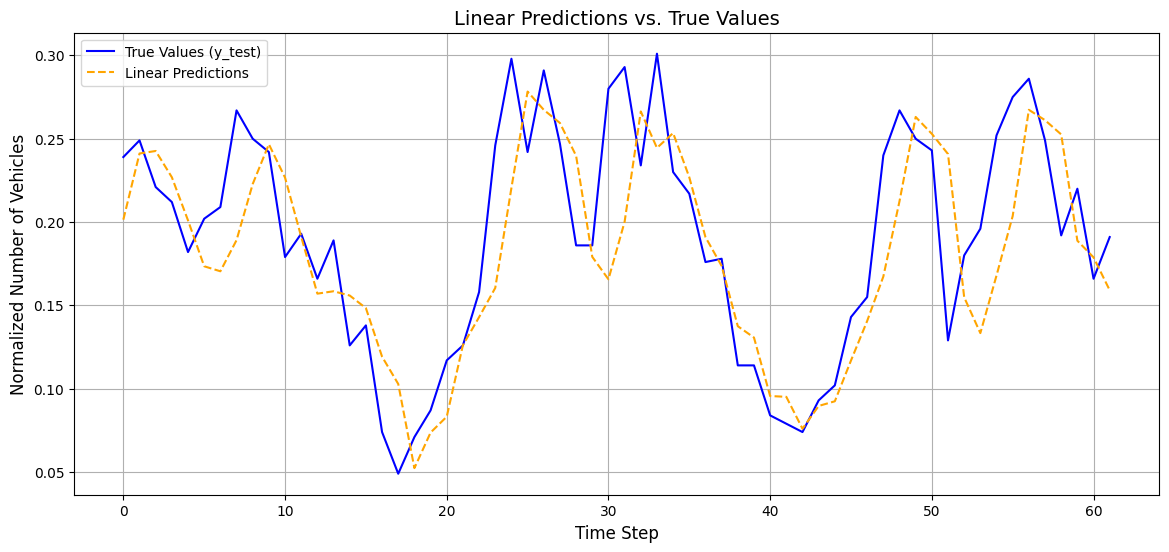

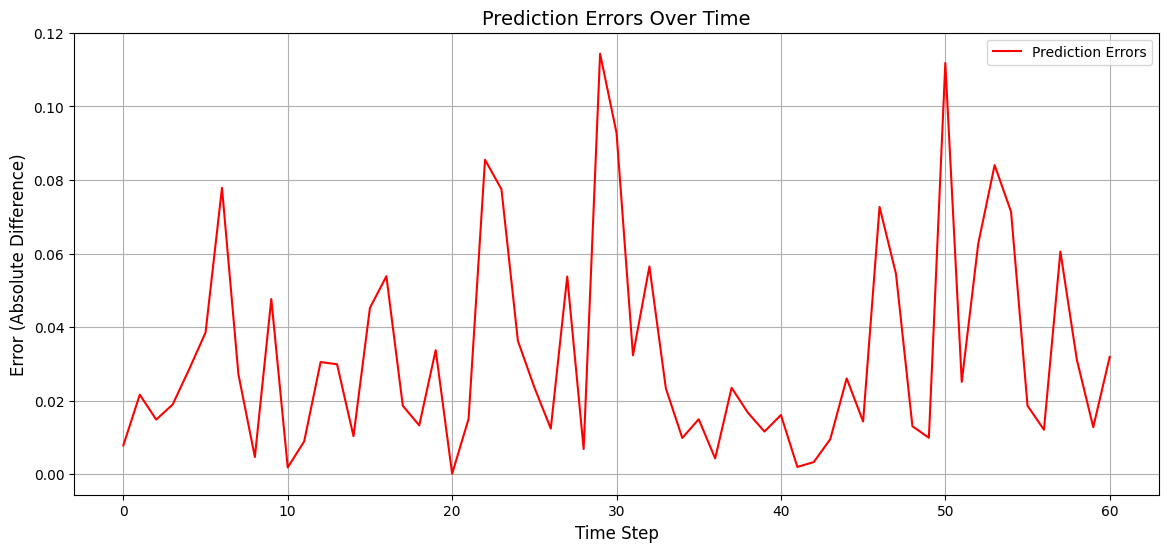

0.032702218471996246

In [36]:
evaluate_model(linear_model, X_test, y_test, "Linear", verbose=True)

### Implement a RNN model.  RNNPredictor 


You can try with different predictor window_sizes my result is just using previous 1 value to predict the next value. My model was as follows:

rnn_model = RNNPredictor(1, 64, 1)

I did not clean the errors in first or last time-steps. I am sure you can do better.

In [44]:
class RNNPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  
        out, _ = self.rnn(x, h0)  
        out = self.fc(out[:, -1, :])  
        return out



In [42]:
window_size = 8 
data = training_set['NUMBER_OF_VEHICLES'].values
X_train, y_train = prepare_input_sequences(data, window_size)


data_test = test_set['NUMBER_OF_VEHICLES'].values
X_test, y_test = prepare_input_sequences(data_test, window_size)

In [47]:
rnn_input_size = 1
hidden_size = 16
output_size = 1
rnn_model = RNNPredictor(rnn_input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.011041726090771283)

X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
train_model(rnn_model, X_train_rnn, y_train, criterion, batch_size=16, optimizer=optimizer, epochs=250, grad_clip=4.850779272919318, verbose=True)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/250, Loss: 0.000729
Epoch 2/250, Loss: 0.000323
Epoch 3/250, Loss: 0.000249
Epoch 4/250, Loss: 0.000203
Epoch 5/250, Loss: 0.000151
Epoch 6/250, Loss: 0.000109
Epoch 7/250, Loss: 0.000093
Epoch 8/250, Loss: 0.000079
Epoch 9/250, Loss: 0.000079
Epoch 10/250, Loss: 0.000078
Epoch 11/250, Loss: 0.000077
Epoch 12/250, Loss: 0.000076
Epoch 13/250, Loss: 0.000076
Epoch 14/250, Loss: 0.000076
Epoch 15/250, Loss: 0.000076
Epoch 16/250, Loss: 0.000076
Epoch 17/250, Loss: 0.000076
Epoch 18/250, Loss: 0.000076
Epoch 19/250, Loss: 0.000076
Epoch 20/250, Loss: 0.000076
Epoch 21/250, Loss: 0.000076
Epoch 22/250, Loss: 0.000076
Epoch 23/250, Loss: 0.000076
Epoch 24/250, Loss: 0.000076
Epoch 25/250, Loss: 0.000076
Epoch 26/250, Loss: 0.000076
Epoch 27/250, Loss: 0.000076
Epoch 28/250, Loss: 0.000076
Epoch 29/250, Loss: 0.000076
Epoch 30/250, Loss: 0.000075
Epoch 31/250, Loss: 0.000075
Epoch 32/250, Loss: 0.000075
Epoch 33/250, Loss: 0.000075
Epoch 34/250, Loss: 0.000075
Epoch 35/250, Loss: 0.0

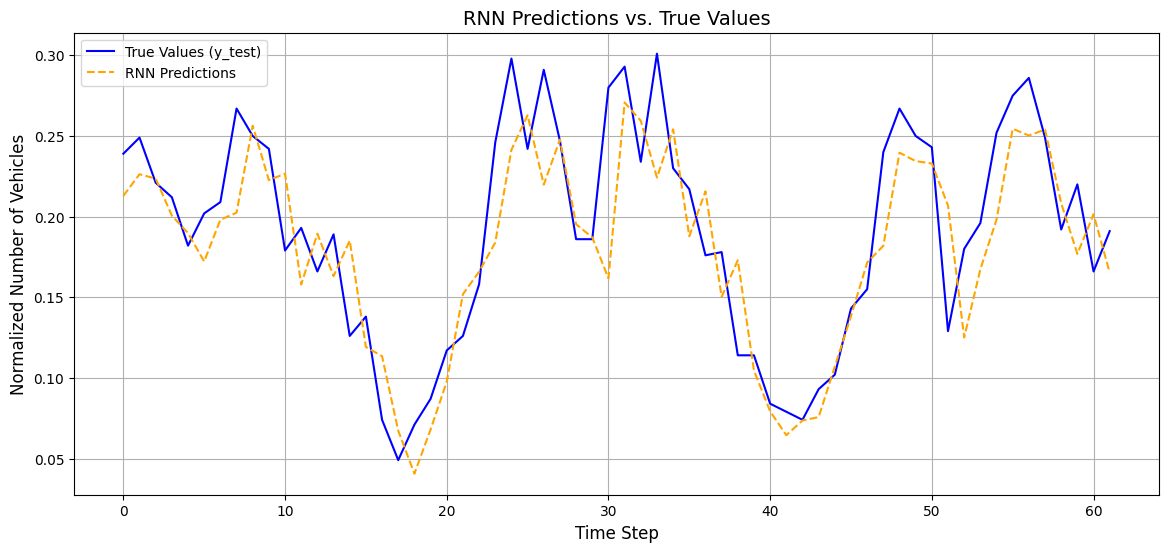

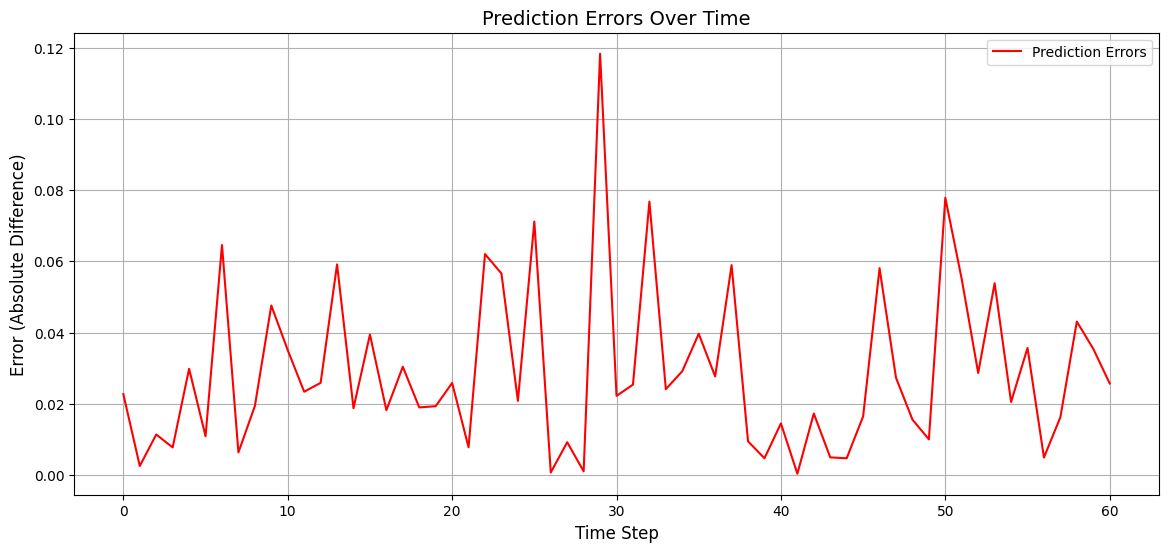

0.028983352618832742

In [48]:
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

evaluate_model(rnn_model, X_test_rnn, y_test, "RNN", verbose=True)


## Implement a CNN model. CNNPredictor
You can try with different predictor window_sizes my result is just using previous 1 value to predict the next value. My model was as follows:

cnn_model = ConvPredictor(1, num_filters=4, 1

I did not clean the errors in first or last time-steps. I am sure you can do better.

However, applying convolution, make sure you do not break the causality. Using the future values (to be predicted values) as input in the model. 

In [43]:
class ConvPredictor(nn.Module):
    def __init__(self, input_size, num_filters, output_size):
        super(ConvPredictor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1) 
        x = self.conv1(x)
        x = self.relu(x)
        x = x.mean(dim=2)  
        x = self.fc(x)
        return x

In [50]:
window_size = 8 
data = training_set['NUMBER_OF_VEHICLES'].values
X_train, y_train = prepare_input_sequences(data, window_size)

data_test = test_set['NUMBER_OF_VEHICLES'].values
X_test, y_test = prepare_input_sequences(data_test, window_size)

In [52]:
# CNN predictor training example
cnn_input_size = 1
num_filters = 50
output_size = 1
cnn_model = ConvPredictor(cnn_input_size, num_filters, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001238341353457005)


X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
train_model(cnn_model, X_train_cnn, y_train, criterion, optimizer, batch_size=16, epochs=250, grad_clip=0.2683804668210814, verbose=True)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/250, Loss: 0.000305
Epoch 2/250, Loss: 0.000272
Epoch 3/250, Loss: 0.000262
Epoch 4/250, Loss: 0.000255
Epoch 5/250, Loss: 0.000249
Epoch 6/250, Loss: 0.000244
Epoch 7/250, Loss: 0.000240
Epoch 8/250, Loss: 0.000237
Epoch 9/250, Loss: 0.000234
Epoch 10/250, Loss: 0.000231
Epoch 11/250, Loss: 0.000229
Epoch 12/250, Loss: 0.000228
Epoch 13/250, Loss: 0.000226
Epoch 14/250, Loss: 0.000225
Epoch 15/250, Loss: 0.000223
Epoch 16/250, Loss: 0.000222
Epoch 17/250, Loss: 0.000221
Epoch 18/250, Loss: 0.000219
Epoch 19/250, Loss: 0.000218
Epoch 20/250, Loss: 0.000217
Epoch 21/250, Loss: 0.000216
Epoch 22/250, Loss: 0.000214
Epoch 23/250, Loss: 0.000213
Epoch 24/250, Loss: 0.000212
Epoch 25/250, Loss: 0.000210
Epoch 26/250, Loss: 0.000209
Epoch 27/250, Loss: 0.000208
Epoch 28/250, Loss: 0.000206
Epoch 29/250, Loss: 0.000205
Epoch 30/250, Loss: 0.000203
Epoch 31/250, Loss: 0.000202
Epoch 32/250, Loss: 0.000201
Epoch 33/250, Loss: 0.000199
Epoch 34/250, Loss: 0.000198
Epoch 35/250, Loss: 0.0

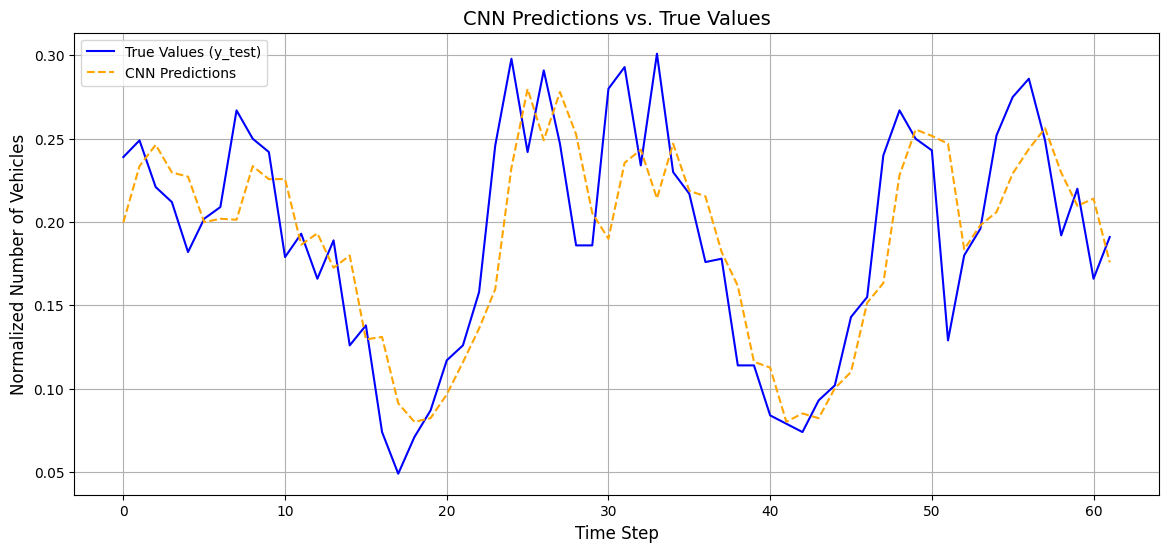

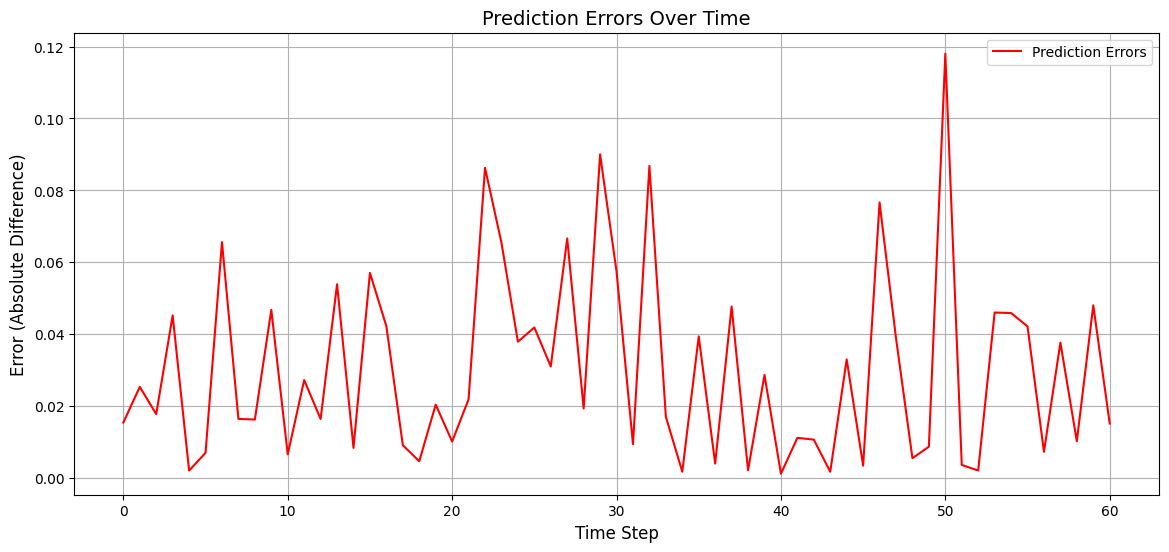

0.0302489755595884

In [53]:
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

evaluate_model(cnn_model, X_test_cnn, y_test, "CNN", verbose=True)

## [EXTRA] OPTUNA for all configurations

In [47]:
# import optuna 

def objective(trial, model_class, X_train, y_train, X_val, y_val):
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)
    batch_size = trial.suggest_categorical("batch_size", [1, 16, 32, 64])
    grad_clip = trial.suggest_float("grad_clip", 0.1, 5.0)
    hidden_size = trial.suggest_int("hidden_size", 16, 128) if model_class == RNNPredictor else None
    num_filters = trial.suggest_int("num_filters", 4, 64) if model_class == ConvPredictor else None
    kernel_size = trial.suggest_int("kernel_size", 3, 7) if model_class == TCNPredictor else None
    num_layers = trial.suggest_int("num_layers", 1, 5) if model_class == TCNPredictor else None
    
    if model_class == LinearPredictor:
        model = model_class(X_train.shape[1], 1)
    elif model_class == RNNPredictor:
        model = model_class(1, hidden_size, 1)
    elif model_class == ConvPredictor:
        model = model_class(1, num_filters, 1)
    elif model_class == TCNPredictor:
        model = model_class(1, num_filters, 1, kernel_size=kernel_size, num_layers=num_layers)
        
    model = model.to(torch.device(device))

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_model(model, X_train, y_train, criterion, optimizer, batch_size, epochs=250, grad_clip=grad_clip)

    mae = evaluate_model(model, X_val, y_val)

    return mae

# linear_db = "linear_predictor_study.db"
# rnn_db = "rnn_predictor_study.db"
# cnn_db = "cnn_predictor_study.db"

# study_linear = optuna.create_study(direction="minimize", storage=f"sqlite:///{linear_db}", study_name="LinearPredictorStudy", load_if_exists=True)
# study_rnn = optuna.create_study(direction="minimize", storage=f"sqlite:///{rnn_db}", study_name="RNNPredictorStudy", load_if_exists=True)
# study_cnn = optuna.create_study(direction="minimize", storage=f"sqlite:///{cnn_db}", study_name="ConvPredictorStudy", load_if_exists=True)

# study_linear.optimize(lambda trial: objective(trial, LinearPredictor, X_train, y_train, X_test, y_test), n_trials=20)
# study_rnn.optimize(lambda trial: objective(trial, RNNPredictor, X_train_rnn, y_train, X_test_rnn, y_test), n_trials=20)
# study_cnn.optimize(lambda trial: objective(trial, ConvPredictor, X_train_cnn, y_train, X_test_cnn, y_test), n_trials=20)

# print("Best parameters for LinearPredictor:", study_linear.best_params)
# print("Best parameters for RNNPredictor:", study_rnn.best_params)
# print("Best parameters for ConvPredictor:", study_cnn.best_params)

# print("Best trial for LinearPredictor:", study_linear.best_trial)
# print("Best trial for RNNPredictor:", study_rnn.best_trial)
# print("Best trial for ConvPredictor:", study_cnn.best_trial)

## Train an Temporal Convolution Network or Transformer model. What factors influenced your decision?
a) Explain the important features of the dataset (e.g., size, patterns, noise, or missing values) that affected your choice of model. Compare these features with the strengths and weaknesses of TCNs and Transformers.

b) Which pre-trained transformer model (if any) did you use, and why? Explain why you chose your model design (e.g., number of layers, kernel sizes for TCN, or initialization, fine-tuning, attention heads for Transformers). How do these choices match the dataset and the prediction task?

<span style="color:red;">Answers:</span> I have a relatively small dataset with approximately 375 samples. Because of this, I decided to train a **Temporal Convolutional Network (TCN)**. TCNs are well-suited for small datasets and are capable of capturing the temporal dependencies that exist in my data.

##### **Strengths of TCNs**
- Efficient for smaller datasets and shorter sequences.
- Computationally less expensive compared to Transformers.
##### **Weaknesses of TCNs**
- Noise intolerance

##### **Strengths of Transformers**
- Good at capturing long-term dependencies

##### **Weaknesses of Transformers**
- Computationally expensive
- It needs large dataset

In [31]:
import torch.nn as nn
import torch.optim as optim 

class TCNPredictor(nn.Module):
    def __init__(self, input_size, num_filters, output_size, kernel_size=3, num_layers=3):
        super(TCNPredictor, self).__init__()
        layers = []
        for i in range(num_layers):
            in_channels = input_size if i == 0 else num_filters
            layers.append(nn.Conv1d(in_channels, num_filters, kernel_size, padding=(kernel_size - 1), dilation=2**i))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        self.tcn = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1) 
        x = self.tcn(x)
        x = x[:, :, -1]  
        x = self.fc(x)
        return x

In [53]:
window_size = 8 
data = training_set['NUMBER_OF_VEHICLES'].values
X_train, y_train = prepare_input_sequences(data, window_size)

data_test = test_set['NUMBER_OF_VEHICLES'].values
X_test, y_test = prepare_input_sequences(data_test, window_size)

In [54]:
# TCN predictor training example
tcn_input_size = 1
num_filters = 128
output_size = 1
tcn_model = TCNPredictor(tcn_input_size, num_filters, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(tcn_model.parameters(), lr=0.0001)

In [55]:
X_train_tcn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
train_model(tcn_model, X_train_tcn, y_train, criterion, optimizer, batch_size=1, epochs=500, grad_clip=0.05, verbose=True)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Loss: 0.006934
Epoch 2/500, Loss: 0.005103
Epoch 3/500, Loss: 0.004319
Epoch 4/500, Loss: 0.003246
Epoch 5/500, Loss: 0.003224
Epoch 6/500, Loss: 0.002859
Epoch 7/500, Loss: 0.002552
Epoch 8/500, Loss: 0.002394
Epoch 9/500, Loss: 0.002178
Epoch 10/500, Loss: 0.002526
Epoch 11/500, Loss: 0.002459
Epoch 12/500, Loss: 0.002052
Epoch 13/500, Loss: 0.002338
Epoch 14/500, Loss: 0.001981
Epoch 15/500, Loss: 0.001992
Epoch 16/500, Loss: 0.001891
Epoch 17/500, Loss: 0.001778
Epoch 18/500, Loss: 0.001976
Epoch 19/500, Loss: 0.002010
Epoch 20/500, Loss: 0.001861
Epoch 21/500, Loss: 0.002081
Epoch 22/500, Loss: 0.002053
Epoch 23/500, Loss: 0.001963
Epoch 24/500, Loss: 0.001910
Epoch 25/500, Loss: 0.001684
Epoch 26/500, Loss: 0.001636
Epoch 27/500, Loss: 0.001862
Epoch 28/500, Loss: 0.001731
Epoch 29/500, Loss: 0.001696
Epoch 30/500, Loss: 0.001830
Epoch 31/500, Loss: 0.001715
Epoch 32/500, Loss: 0.001685
Epoch 33/500, Loss: 0.001873
Epoch 34/500, Loss: 0.001683
Epoch 35/500, Loss: 0.0

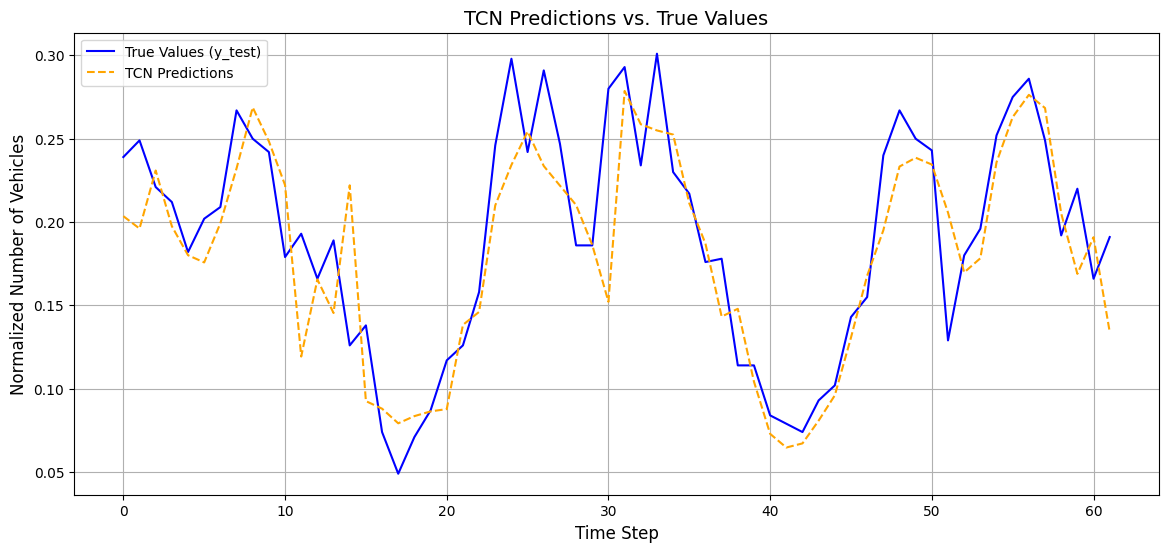

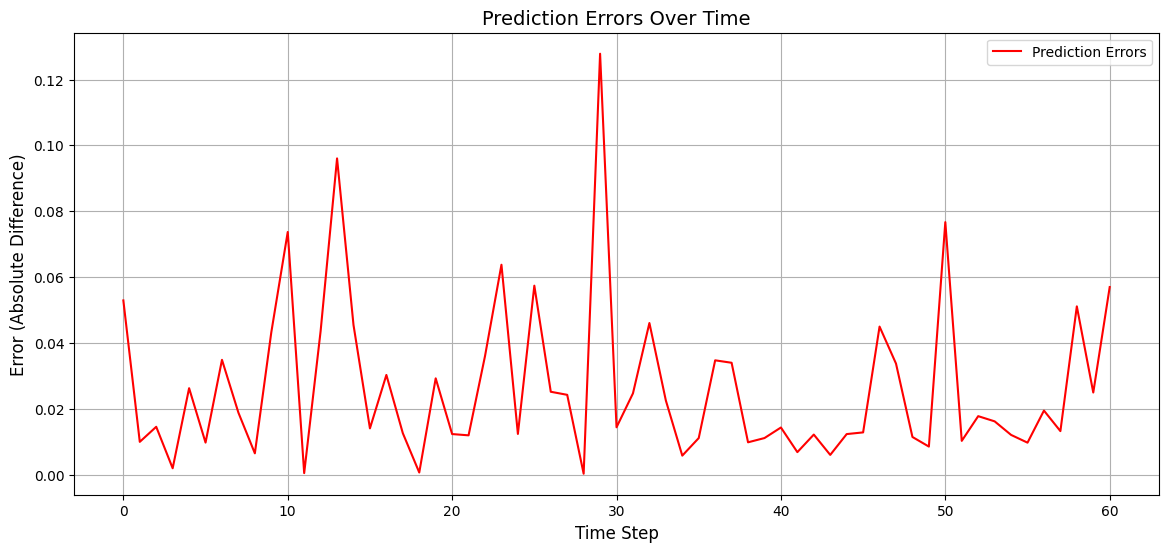

0.026699285585072733

In [56]:
X_test_tcn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
evaluate_model(tcn_model, X_test_tcn, y_test, "TCN", verbose=True)

In [57]:
# import optuna

# tcn_db = "tcn_study.db"
# study_tcn = optuna.create_study(direction="minimize", storage=f"sqlite:///{tcn_db}", study_name="TCNStudy", load_if_exists=True)
# study_tcn.optimize(lambda trial: objective(trial, TCNPredictor, X_train_tcn, y_train, X_test_tcn, y_test), n_trials=20)
# print("Best parameters for TCNPredictor:", study_tcn.best_params)
# print("Best trial for TCNPredictor:", study_tcn.best_trial)


## Compare all the obtained results. 

In [59]:
results = {
    "Linear Model": {"MAE": 0.032702218471996246},
    "RNN": {"MAE": 0.028983352618832742},
    "CNN": {"MAE": 0.0302489755595884},
    "TCN": {"MAE": 0.026699285585072733},
}

for model, metrics in results.items():
    print(f"{model}: MAE = {metrics['MAE']:.6f}")


Linear Model: MAE = 0.032702
RNN: MAE = 0.028983
CNN: MAE = 0.030249
TCN: MAE = 0.026699


#### **Linear Model**
- This model provides baseline performance and is easy to interpret.

#### **RNN**
- RNNs performed better with help of its memory cells.
- Vanishing gradient problem

#### **CNN**
- Performed better than linear since it can capture short dependencies.

#### **TCN (Temporal Convolutional Network)**
- It is computationally effiecend and performed well.


#### **Conclusion**
As a result for small datasets TCN performs well.
